In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ccdproc
from ccdproc import ImageFileCollection as IFC
from astropy.nddata import CCDData
from astropy.modeling import models, fitting, powerlaws
from astropy import units as u
from astropy import constants as const

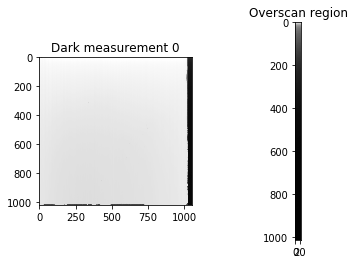

ERROR:ccdproc.image_collection:error writing file ./Template_scripts/darks-bias/dark_0000-bias.fits


FileNotFoundError: [Errno 2] No such file or directory: './Template_scripts/darks-bias/dark_0000-bias.fits'

In [5]:
# from dark measurement read temperature and count median, standard deviation
#
# To read .fits file use IFC(<path_to_files>, glob_include = file name start*, keywords = interested key in header)
# The structure of a .fits file is Header Data Units(HDU)
# Each HDU contains .header (header information ~ key-value pair, labels of data) and .data (image information ~ array)
# To get value of header information use IFC(...).values(<key>) or IFC(...).summary[<key>].data
# More info: https://ccdproc.readthedocs.io/en/latest/api/ccdproc.ImageFileCollection.html#ccdproc.ImageFileCollection.hdus
#
dark = IFC('./Template_scripts/darks/',glob_include='dark_*', keywords=['ccdtemp', 'datamedi', 'datastdv']) 
temp,med,stddev=np.asarray(dark.values("ccdtemp"))+273.15,np.asarray(dark.values("datamedi")),np.asarray(dark.values("datastdv"))

# use program ds9 we read the overscan region(= bias region) for dark_0000.fits is about (row[10:1024] colomn[1025:1050])
# a list of median bias values and the standard deviations in the overscan region
bias_med = []
bias_std = []

for idx, hdu in enumerate(dark.hdus(save_with_name = "-bias", save_location = './Template_scripts/darks-bias/')):
    bias = CCDData(hdu.data[10:1024,1025:1050], unit="electron")
    bias_med.append(np.median(np.asarray(bias)))
    bias_std.append(np.std(np.asarray(bias)))
    # Correct each of the dark measurements with their corresponding median bias value
    hdu.data = hdu.data - np.median(np.asarray(bias))
    if idx == 0:
        # plot of the whole image
        pic = CCDData(hdu.data, unit="electron") # convert hdu(array) to pic(CCDData) first
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(pic, cmap='Greys_r')
        ax1.set_title("Dark measurement 0")
        # plot of overscan region
        ax2.imshow(bias, cmap='Greys_r')
        ax2.set_title("Overscan region")
        plt.show()

In [10]:
dark_no_bias = IFC('./Template_scripts/darks-bias/',glob_include='dark_*', keywords=['datamedi', 'datastdv']) 

print(type(dark_no_bias))

med_no_bias =[]
# use program ds9 we read the image region for dark_0000.fits is about (row[30:1014] colomn[0:1010])
for hdu in dark_no_bias.hdus(overwrite = True):
    img = CCDData(hdu.data[30:1014,0:1010], unit="electron")
    med_no_bias.append(np.median(np.asarray(img)))

ERROR:ccdproc.image_collection:error writing file ./Template_scripts/darks-bias\dark_0000-bias.fits


<class 'ccdproc.image_collection.ImageFileCollection'>


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: './Template_scripts/darks-bias\\dark_0000-bias.fits'

In [ ]:
# dark measurement analysis -> calculate band gap of silicon based on equ. (12) on script
def expon(x,A,k): 
    return A*np.exp(x*k)
para, paraerr = curve_fit(expon, 1/temp[4:32], (med*temp**(-3/2))[4:32], p0 = (3.2e10, -6000))
E_g = para[1]*u.K*(-2*const.k_B)
E_g_err = paraerr[1][1]*u.K*(-2*const.k_B)
plt.plot(1/temp, expon(1/temp, para[0], para[1]), label='Exponential fit', color='red')
plt.errorbar(1/temp, med*temp**(-3/2), yerr=stddev*temp**(-3/2), marker='x', ls='none', color='blue', label = 'data')
plt.xlabel("1/T [$K^{-1}$]")
plt.ylabel("counts*$T^{-3/2}$")
plt.yscale('log')
plt.title("Band gap of silicon")
plt.axis([0.0034, 0.0050, 3e-1, 16])
plt.legend()
plt.show()
print("Band gap of silicon = ",E_g.to(u.eV),"+ \\",E_g_err.to(u.eV))
print("Literature value = 1.15 eV")

In [ ]:
# from flat field measurement read
keys = ['CCDTEMP', 'DATAMEDI', 'DATASTDV']
dark = IFC('./Template_scripts/darks/',glob_include='dark_*', keywords=keys) # glob_include for file name start
temp, med, stddev = dark.summary['CCDTEMP'].data + 273.15, dark.summary['DATAMEDI'].data, dark.summary['DATASTDV'].data


# test for read
dark = CCDData.read('./Template_scripts/darks/dark_0000.fits', unit="electron")
flat = CCDData.read('./Template_scripts/flats/flat_I_0000.fits', unit="electron")
lin = CCDData.read('./Template_scripts/linearity/linearity_R_0000.fits', unit="electron")
sens = CCDData.read('./Template_scripts/sensitivity/sensitivity_I_1_0000.fits', unit="electron")
#dark_sub = ccdproc.subtract_dark(img, dark, dark_exposure=30*u.second, data_exposure=15*u.second, scale=True)
#dark_sub_gained = ccdproc.gain_correct(dark_sub, 1.5 * u.photon/u.adu, add_keyword='gain_corrected')
head = dark.header
print(head)

In [ ]:
from astropy.io import fits
hdul = fits.open('./Template_scripts/darks/dark_0000.fits')
print(hdul[0].header)
hdul.close()